# ECG-Pytorch-Quantization Compression

@create 2021-09-13
@author 孙寒石
@env Pytorch 1.9.0 Python 3.7

## Import Packages

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Prepare Dataset

In [2]:
import os
import scipy.io as scio
from sklearn.model_selection import train_test_split

base_path = './'
dataset_path =  './Dataset' # Training data

classes = ['NSR', 'APB', 'AFL', 'AFIB', 'SVTA', 'WPW','PVC', 'Bigeminy', 'Trigeminy', 
           'VT', 'IVR', 'VFL', 'Fusion', 'LBBBB', 'RBBBB', 'SDHB', 'PR']
ClassesNum = len(classes)

X = list()
y = list()

for root, dirs, files in os.walk(dataset_path, topdown=False):
    for name in files:
        data_train = scio.loadmat(os.path.join(root, name))# 取出字典里的value
        
        # arr -> list
        data_arr = data_train.get('val')
        data_list = data_arr.tolist()
        
        X.append(data_list[0]) # [[……]] -> [ ]
        y.append(int(os.path.basename(root)[0:2]) - 1)  # name -> num
        
def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range
        

X=np.array(X)
y=np.array(y)
X = X.reshape((1000,1,3600))
y = y.reshape((1000))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("X_train : ", len(X_train))
print("X_test  : ", len(X_test))
print("shape of X_train : ", np.shape(X_train[0]))
print("shape of y_train : ", np.shape(y_train))
print("shape of X_test : ", np.shape(X_test))
print("shape of y_test : ", np.shape(y_test))

X_train :  800
X_test  :  200
shape of X_train :  (1, 3600)
shape of y_train :  (800,)
shape of X_test :  (200, 1, 3600)
shape of y_test :  (200,)


In [3]:
batch_size = 16
class MyDataset(Dataset):
    def __init__(self):
        self.len = X_train.shape[0] # 取第0元素：长度
        self.x_train = torch.from_numpy(X_train).float()
        self.y_train = torch.from_numpy(y_train).long()
    def __getitem__(self, index):
        return self.x_train[index], self.y_train[index] # 返回对应样本即可
    def __len__(self):
        return self.len
    
class TestDataset(Dataset):
    def __init__(self):
        self.len = X_test.shape[0] # 取第0元素：长度
        self.x_test = torch.from_numpy(X_test).float()
        self.y_test = torch.from_numpy(y_test).long()
    def __getitem__(self, index):
        return self.x_test[index], self.y_test[index] # 返回对应样本即可
    def __len__(self):
        return self.len    
        
train_dataset = MyDataset()
test_dataset = TestDataset()
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=0)
test_loader = DataLoader(dataset=test_dataset, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=0)

## Design Model

In [4]:
in_channels_ = 1
num_segments_in_record = 100
segment_len = 3600   # 3600 采样
num_classes = 17

class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

class arrhythmia_classifier(nn.Module):
    def __init__(self, in_channels=in_channels_):
        super(arrhythmia_classifier, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1,8,16),
            nn.ReLU(),
            #nn.BatchNorm1d(8),
            nn.MaxPool1d(kernel_size=8),
   
            nn.Conv1d(8,16,9),
            nn.ReLU(),
            #nn.BatchNorm1d(16),
            nn.MaxPool1d(4),
            
            nn.Conv1d(16,32,9),
            nn.ReLU(),
            nn.MaxPool1d(4,stride=2),
            
            nn.Conv1d(32,64,7),
            nn.ReLU(),
            nn.MaxPool1d(4,stride=1),
            
            nn.Conv1d(64,64,5),
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            nn.Conv1d(64,64,3),
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            nn.Conv1d(64,72,3),
            nn.ReLU(),
            nn.MaxPool1d(2),
            Flatten(),
            nn.Linear(in_features=216, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=17),
        )

    def forward(self, x, ex_features=None):
        return self.cnn(x)


def calc_next_len_conv1d(current_len=112500, kernel_size=16, stride=8, padding=0, dilation=1):
    return int(np.floor((current_len + 2 * padding - dilation * (kernel_size - 1) - 1) / stride + 1))
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = arrhythmia_classifier().to("cpu")

In [5]:
print(model)

arrhythmia_classifier(
  (cnn): Sequential(
    (0): Conv1d(1, 8, kernel_size=(16,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(8, 16, kernel_size=(9,), stride=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(16, 32, kernel_size=(9,), stride=(1,))
    (7): ReLU()
    (8): MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv1d(32, 64, kernel_size=(7,), stride=(1,))
    (10): ReLU()
    (11): MaxPool1d(kernel_size=4, stride=1, padding=0, dilation=1, ceil_mode=False)
    (12): Conv1d(64, 64, kernel_size=(5,), stride=(1,))
    (13): ReLU()
    (14): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
    (16): ReLU()
    (17): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (18): Conv1d(64,

In [6]:
#from torchsummary import summary
#summary(model, input_size=(1, 3600))

## Construct Loss and Optimizer

In [17]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002, betas=(0.9, 0.999), eps=1e-08, weight_decay = 0.0, amsgrad = False)

## Train

In [18]:
correct_list = []
def train(epoch):
    running_loss = 0.0
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, target = data
        optimizer.zero_grad()
        # forward + backward + update
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch_idx % 10 == 9:
            print('[%d, %5d] loss: %.8f' % (epoch + 1, batch_idx + 1, running_loss / 300))
            running_loss = 0.0


def test():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    correct_list.append(100 * correct / total)
    print('Accuracy on test set: %d %%' % (100 * correct / total))
    
    
for epoch in range(10):
    train(epoch)
    test()

[1,    10] loss: 0.00000004
[1,    20] loss: 0.00004309
[1,    30] loss: 0.00015251
[1,    40] loss: 0.00008705
[1,    50] loss: 0.00008864
Accuracy on test set: 80 %
[2,    10] loss: 0.00198799
[2,    20] loss: 0.00001636
[2,    30] loss: 0.00071180
[2,    40] loss: 0.00470854
[2,    50] loss: 0.00264098
Accuracy on test set: 86 %
[3,    10] loss: 0.00041697
[3,    20] loss: 0.00007715
[3,    30] loss: 0.00032230
[3,    40] loss: 0.00000494
[3,    50] loss: 0.00000916
Accuracy on test set: 83 %
[4,    10] loss: 0.00000301
[4,    20] loss: 0.00000465
[4,    30] loss: 0.00001444
[4,    40] loss: 0.00006334
[4,    50] loss: 0.00001093
Accuracy on test set: 85 %
[5,    10] loss: 0.00000572
[5,    20] loss: 0.00000463
[5,    30] loss: 0.00000568
[5,    40] loss: 0.00001056
[5,    50] loss: 0.00000393
Accuracy on test set: 85 %
[6,    10] loss: 0.00000454
[6,    20] loss: 0.00000433
[6,    30] loss: 0.00000239
[6,    40] loss: 0.00000435
[6,    50] loss: 0.00000251
Accuracy on test set: 85 

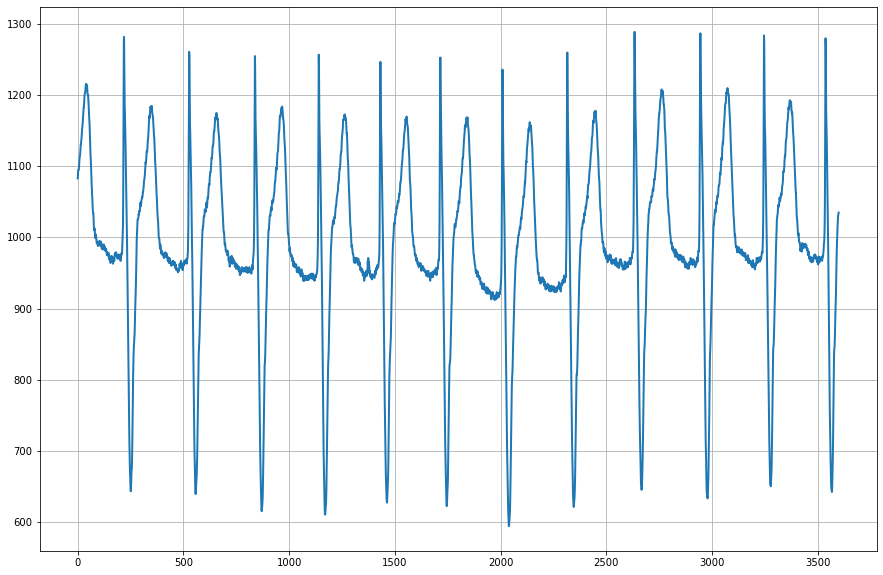

In [19]:
t=np.arange(3600)
p = X_train[1,:,:].reshape((3600))
plt.plot(t,p)

In [20]:
correct = 0
total = 0
with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            print(predicted)
            print(labels)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
print('Accuracy on test set: %d %%' % (100 * correct / total))

tensor([ 7,  6,  7, 13,  0,  6,  6,  6, 16, 13, 15, 12,  1,  0,  3,  1])
tensor([ 7,  6,  7, 13,  0,  6,  6,  6, 16, 13, 15,  1,  1,  0,  3,  1])
tensor([13,  0,  0, 13,  9, 13, 13,  3,  6,  6,  6,  0,  0,  6, 15,  5])
tensor([13,  6,  0, 13,  3, 13, 13,  3,  0,  6,  6,  0,  0,  0, 15,  5])
tensor([14,  1,  0,  1, 13,  3, 14,  3,  3,  6, 14,  6,  1,  0,  0, 12])
tensor([14,  1,  0,  1, 13,  3, 14,  3,  3,  0, 14,  6,  1,  0, 12,  6])
tensor([ 3,  7,  3,  7,  0,  6,  3,  6, 14, 14, 14,  0, 13,  6,  0, 13])
tensor([ 3,  7,  3,  7,  0,  6,  3,  6, 14, 14, 14,  0, 13,  6,  0, 13])
tensor([10,  6,  0,  3,  6,  7, 16,  0, 13,  0,  3, 11,  6,  2,  3,  6])
tensor([10,  6,  0,  3,  6,  7, 16,  0, 13,  0,  3, 11,  0,  2,  3,  6])
tensor([ 3, 16,  7, 13,  0, 13,  2, 11,  6, 13,  3,  0,  0,  4,  6,  0])
tensor([ 3, 16,  7, 13,  0, 13,  2, 11,  6, 13,  1,  0,  0,  2,  6,  0])
tensor([ 3,  6,  0, 14,  0,  6,  3, 14,  5, 15,  7,  6,  6, 14,  0, 16])
tensor([ 3,  6,  0, 14,  0,  6,  3, 14,  5, 15,  8,

Text(0, 0.5, 'Accuracy(%)')

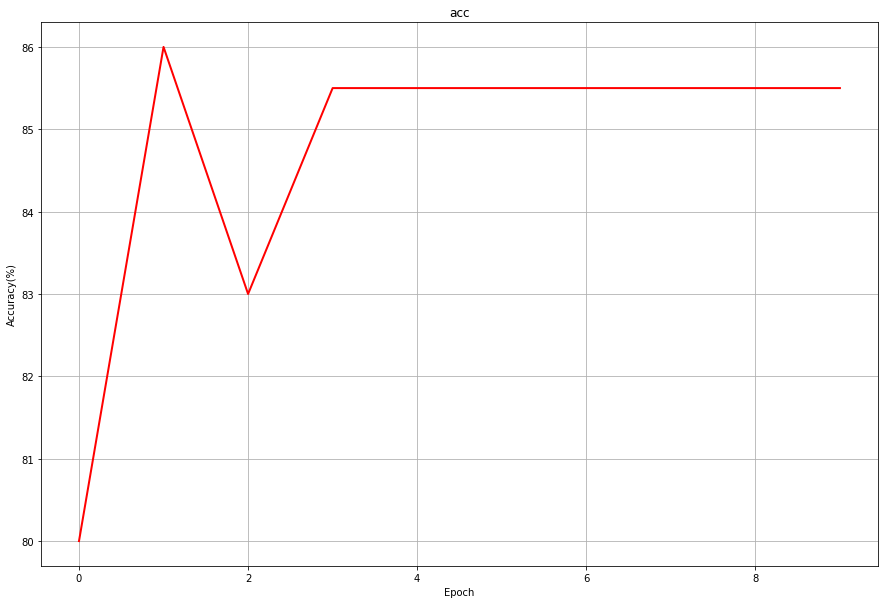

In [22]:
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.grid'] = True
plt.plot(correct_list,'r')
plt.title('acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy(%)')

In [23]:
torch.save(model, 'acc85.pt')

In [24]:
layer_name = list(model.state_dict().keys())

In [25]:
layer_name

['cnn.0.weight',
 'cnn.0.bias',
 'cnn.3.weight',
 'cnn.3.bias',
 'cnn.6.weight',
 'cnn.6.bias',
 'cnn.9.weight',
 'cnn.9.bias',
 'cnn.12.weight',
 'cnn.12.bias',
 'cnn.15.weight',
 'cnn.15.bias',
 'cnn.18.weight',
 'cnn.18.bias',
 'cnn.22.weight',
 'cnn.22.bias',
 'cnn.24.weight',
 'cnn.24.bias']

In [27]:
kk =  model.state_dict()[ layer_name[2] ]

In [29]:
for i in kk:
    plt.scatter(i)

TypeError: scatter() missing 1 required positional argument: 'y'

In [35]:
kk.size()

torch.Size([1, 1152])

In [36]:
kk

tensor([[-0.0222,  0.0596,  0.0165,  ..., -0.0234, -0.0364, -0.0444]])

In [38]:
kk=kk.numpy()

In [42]:
kk.reshape((1152))
kk=kk.tolist()

AttributeError: 'list' object has no attribute 'values'

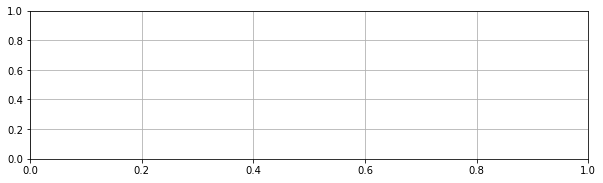

In [43]:
fig = plt.figure(figsize = (10,6))
ax1 = fig.add_subplot(2,1,1)  # 创建子图1
ax1.scatter(kk.index, kk.values)
plt.grid()